In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
  # Import all the tools we need


# Regular EDA(exploratory data analysis) and plotting libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
%matplotlib inline

def setup_data(df):
    '''
    Preprocess some basic works
    '''
    # Drop every column except the specified column
    df = df[['rating', 'review']]
    # Drop Null rows
    df = df[~(df == 'Null').any(axis=1)]
    return df

def remove_big_review(rev):
    '''
    Removes big review greter than length
    '''
    if len(rev)>3000:
        rev = 'Null'
    return rev

def clean_text(test):
    '''
    Clean's up the unnecessary thiings of a text by replacing them with proper symbols.
    '''
    test = test.replace('<br/>', '')
    test = test.replace('--', ' ')
    test = test.replace("'", '')
    test = test.replace('"','')
#     test = test.replace('.', '')
    test = test.replace(',', '')
#     test = test.replace('?', '')
#     test = test.replace('!', '')
    test = test.replace('\n', '')
    test = test.replace('(', '')
    test = test.replace(')', '')
    test = test.lower()
    return test


def level(x):
    '''
    Changes predicted levels to human brain level.
    '''
    if x in [10, 9]:
        x = 0
    elif x in [7, 6, 8]:
        x = 1
    elif x in [5, 4, 3]:
        x = 2
    elif x in [1, 2]:
        x = 3
    return x

def level2(x):
    '''
    Changes predicted levels to human brain level.
    '''
    if x > 5:
        x = 0
    else:
        x = 1
    return x

def plot_rate(df):
    df.label.value_counts().plot(kind='bar', cmap='summer', title='IMDb Rating');

In [2]:
data = pd.read_csv('/kaggle/input/movie-review/data.csv')

In [3]:
data.head(2)

,rating,review
0,10,Wow. That's all I can say. I was freaked out a...
1,10,The Dark Knight Rises capped off what is proba...


In [5]:
data.shape

(18502, 2)

In [4]:
df = data
df.review = df.review.apply(remove_big_review)
df = setup_data(df)
# df.shape
# Clean the text removing unnecessary things
df['review'] = df['review'].apply(clean_text)
df.rating = df.rating.astype(int)
data = df

In [5]:
data.columns=['label','text']

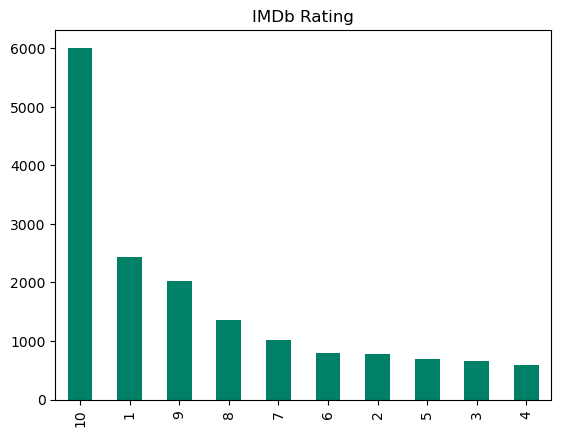

In [8]:
plot_rate(data)

In [6]:
data.shape

(16353, 2)

In [7]:
main_df = data.copy()

In [8]:
data.label = data.label.apply(level)

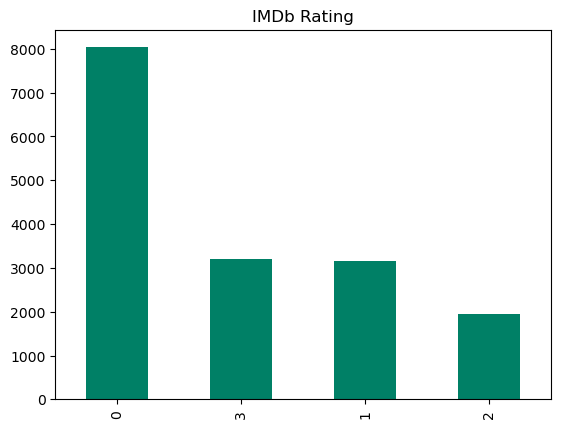

In [9]:
plot_rate(data)

In [12]:
level_df = pd.DataFrame({'level': [0, 1, 2, 3],
                         'range': [[10, 9], [8,7,6], [3,4,5], [1,2]]})
level_df

,level,range
0,0,"[10, 9]"
1,1,"[8, 7, 6]"
2,2,"[3, 4, 5]"
3,3,"[1, 2]"


## Model S
This Model Analyses the sentiment of the review. Positive or negetive.

In [12]:
main_df.label.value_counts()

10    6015
1     2428
9     2018
8     1360
7     1011
6      795
2      777
5      699
3      664
4      586
Name: label, dtype: int64

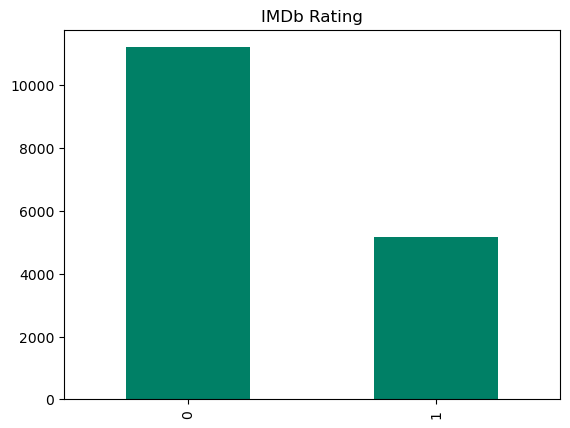

In [13]:
sdf = main_df.copy()
sdf.label = sdf.label.apply(level2)
plot_rate(sdf)

In [18]:
sdf.shape

(16353, 2)

> ## Word Clouding

In [37]:
from wordcloud import WordCloud
def display_wc(text, titel):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(titel)
    plt.show()

In [39]:
# Initialize an empty string
text = ''

# Iterate through each row of the dataframe
for index, row in sdf.iterrows():
    review = row['text']  # Get the review from the current row
    text += review + ' '   # Append the review to the text string with a space


## For OverAll Data

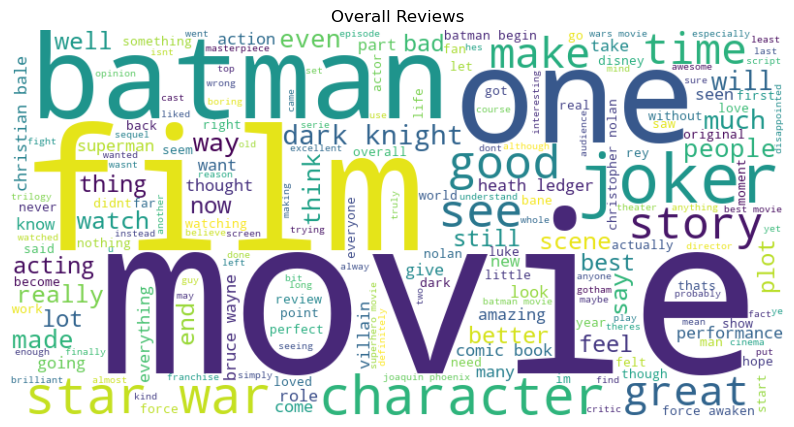

In [40]:
display_wc(text, 'Overall Reviews')

In [148]:
np.random.seed(42)
train, test = train_test_split(sdf, test_size=0.2)
len(train), len(test)

(13082, 3271)

In [16]:
train.to_csv('/kaggle/working/s_train.csv', index=False)
test.to_csv('/kaggle/working/s_test.csv', index=False)

In [149]:
test.head(2)

,label,text
500,0,the movie takes us to rise of batman and revea...
6551,0,joaquin nailed the joker character. who would ...


In [139]:
from datasets import load_dataset
from transformers import BertTokenizer, TFBertModel,AutoTokenizer
from transformers import DataCollatorWithPadding

dataset = load_dataset('csv', data_files={'train':'/kaggle/working/s_train.csv',
                                              'test':'/kaggle/working/s_test.csv'})

tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True,padding=True)

tokenized_data = dataset.map(preprocess_function, batched=True)

data_collator=DataCollatorWithPadding(tokenizer=tokenizer,return_tensors='tf')

id2label = {0:0,1:1}
label2id = {0:0,1:1}
from transformers import create_optimizer
import tensorflow as tf
batch_size=16
num_epochs=2
batch_per_epoch=len(tokenized_data["train"])
total_train_steps=int(batch_per_epoch*num_epochs)
optimizer,schedule=create_optimizer(init_lr=2e-5,num_warmup_steps=0,num_train_steps=total_train_steps)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

In [140]:
from transformers import TFAutoModelForSequenceClassification
modelS=TFAutoModelForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',num_labels=2,id2label=id2label,label2id=label2id,ignore_mismatched_sizes=True
    
)
tf_train_set = modelS.prepare_tf_dataset(
    tokenized_data["train"],
    shuffle=True,
    batch_size=16,
    collate_fn=data_collator,
)
tf_validation_set = modelS.prepare_tf_dataset(
    tokenized_data["test"],
    shuffle=False,
    batch_size=16,
    collate_fn=data_collator,
)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [141]:
modelS.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')])

In [142]:
# Slice the dataset from length 100 to 10
n = 50
sliced_dataset_train = tf_train_set.take(n)
sliced_dataset_test = tf_validation_set.take(n)

In [143]:
sliced_dataset_test

<_TakeDataset element_spec=({'input_ids': TensorSpec(shape=(None, None), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(None, None), dtype=tf.int64, name=None)}, TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [144]:
modelS.fit(x=tf_train_set,validation_data=tf_validation_set, epochs=1)

817/817 [==============================] - 822s 975ms/step - loss: 0.2819 - accuracy: 0.8796 - val_loss: 0.2219 - val_accuracy: 0.9092


In [23]:
def custom_test(text, model):
    inputs=tokenizer(text,return_tensors="tf")
    tf_outputs = model(inputs)                                  
    tf_predictions = tf.nn.softmax(tf_outputs[0], axis=-1) 
    # print(tf_predictions)
    logits=modelS(**inputs).logits
    # print("Logits :",logits)
    predicted_class_id = int(tf.math.argmax(logits, axis=-1)[0])
    return predicted_class_id

In [24]:
text = 'This is a very bad movie. I hatedit. Very bad screenplay. Very bad direction and hope not to see it again.'
custom_test(text, modelS)

1

In [25]:
text = 'Very good movie. I loved every part of it. Highly recommended for everyone'
custom_test(text, modelS)

0

In [150]:
true = list(test[:50].label)
test_text = list(test[:50].text)

In [151]:
true[:15]

[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0]

Token indices sequence length is longer than the specified maximum sequence length for this model (521 > 512). Running this sequence through the model will result in indexing errors


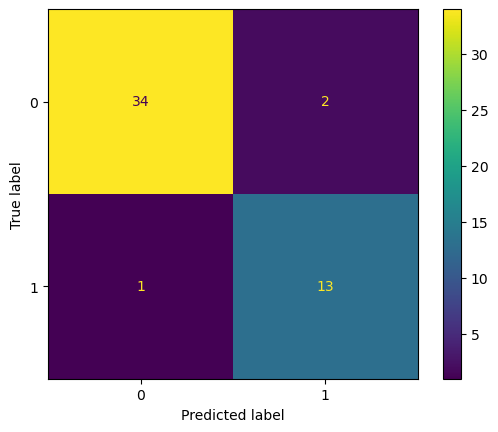

In [152]:
preds = []
for text in test_text:
    preds.append(custom_test(text, modelS))
    
    
from sklearn.metrics import confusion_matrix
from sklearn import metrics

# Make our confusion matrixx more visual with Seaborn's heatmap()
import seaborn as sb

con_mat = confusion_matrix(true, preds)

con_mat_plot = metrics.ConfusionMatrixDisplay(confusion_matrix=con_mat, display_labels=[0,1])
con_mat_plot.plot()
plt.show()

## ModelUP

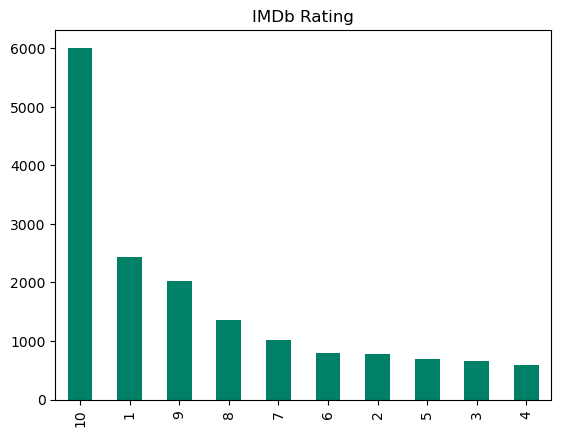

In [31]:
plot_rate(main_df)

In [22]:
updf = main_df[main_df['label'] > 5].copy()

In [23]:
updf.label.value_counts()

10    6015
9     2018
8     1360
7     1011
6      795
Name: label, dtype: int64

In [24]:
def level_up(x):
    '''
    Changes predicted levels to human brain level.
    '''
    if x in [10, 9]:
        x = 0
    elif x in [8, 7, 6]:
        x = 1
    return x

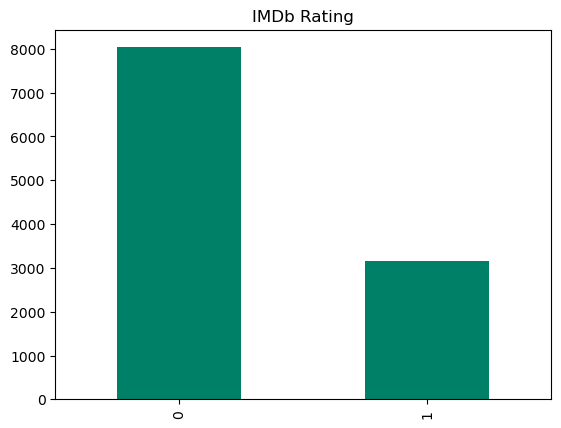

In [25]:
updf['label'] = updf['label'].apply(level_up)
plot_rate(updf)

In [26]:
def drop_ten(n, df):
    
    for i in range(n):
        ind_to_drop = np.random.randint(1,10000)
        try:
            if df.label[ind_to_drop] == 0:
                df = df.drop(ind_to_drop)
        except:
            continue
    return df

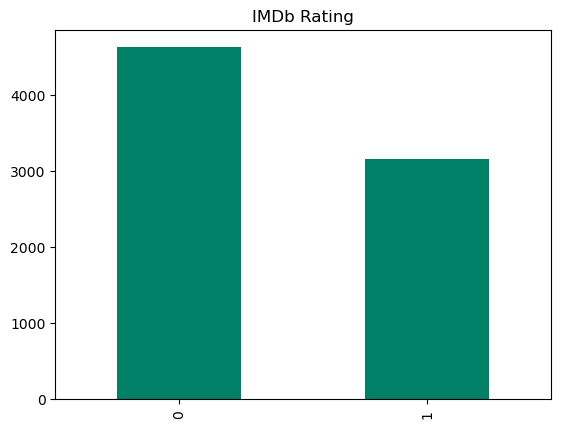

In [30]:
updf = drop_ten(2000, updf)
plot_rate(updf)

## Word Clouding

In [41]:
# Initialize an empty string
text = ''

# Iterate through each row of the dataframe
for index, row in updf.iterrows():
    review = row['text']  # Get the review from the current row
    text += review + ' '   # Append the review to the text string with a space


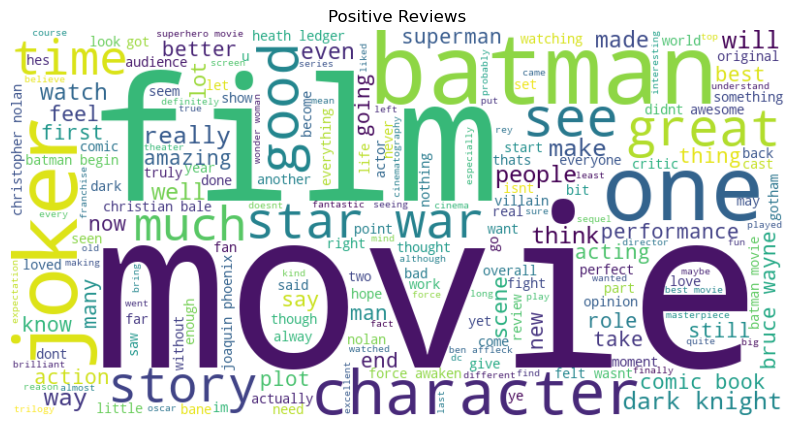

In [42]:
display_wc(text, 'Positive Reviews')

In [44]:
updf.to_csv('/kaggle/working/up_data.csv', index=False)

In [31]:
np.random.seed(42)
train, test = train_test_split(updf, test_size=0.2)
len(train), len(test)

(6236, 1560)

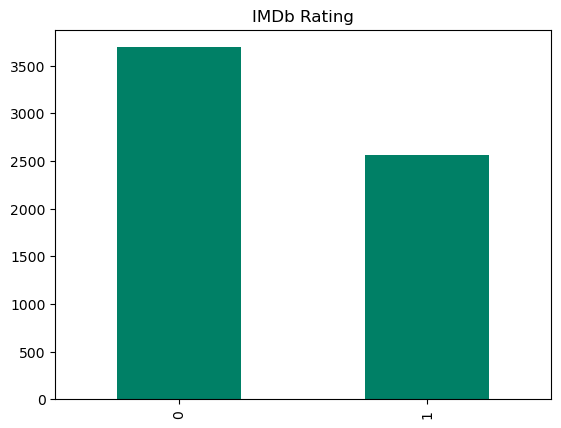

In [57]:
plot_rate(train)

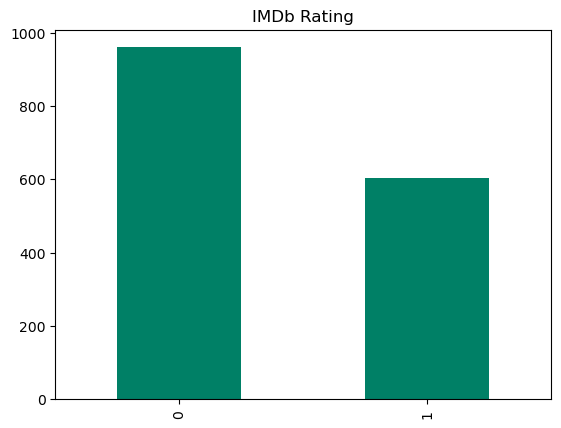

In [58]:
plot_rate(test)

In [61]:
train.to_csv('/kaggle/working/u_train.csv', index=False)
test.to_csv('/kaggle/working/u_test.csv', index=False)

In [62]:
dataset = load_dataset('csv', data_files={'train':'/kaggle/working/u_train.csv',
                                              'test':'/kaggle/working/u_test.csv'})

tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

tokenized_data = dataset.map(preprocess_function, batched=True)

data_collator=DataCollatorWithPadding(tokenizer=tokenizer,return_tensors='tf')

id2label = {0:0,1:1}
label2id = {0:0,1:1}
from transformers import create_optimizer
import tensorflow as tf
batch_size=16
num_epochs=2
batch_per_epoch=len(tokenized_data["train"])
total_train_steps=int(batch_per_epoch*num_epochs)
optimizer,schedule=create_optimizer(init_lr=2e-5,num_warmup_steps=0,num_train_steps=total_train_steps)

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-bdbfcf7e9bf2be8d/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


/opt/conda/lib/python3.10/site-packages/datasets/packaged_modules/csv/csv.py:154: FutureWarning: the 'mangle_dupe_cols' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'mangle_dupe_cols'
  csv_file_reader = pd.read_csv(file, iterator=True, dtype=dtype, **self.config.read_csv_kwargs)
/opt/conda/lib/python3.10/site-packages/datasets/packaged_modules/csv/csv.py:154: FutureWarning: the 'mangle_dupe_cols' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'mangle_dupe_cols'
  csv_file_reader = pd.read_csv(file, iterator=True, dtype=dtype, **self.config.read_csv_kwargs)


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

In [63]:
modelUP=TFAutoModelForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',num_labels=2,id2label=id2label,label2id=label2id,ignore_mismatched_sizes=True
    
)
tf_train_set = modelUP.prepare_tf_dataset(
    tokenized_data["train"],
    shuffle=True,
    batch_size=16,
    collate_fn=data_collator,
)
tf_validation_set = modelUP.prepare_tf_dataset(
    tokenized_data["test"],
    shuffle=False,
    batch_size=16,
    collate_fn=data_collator,
)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [64]:
modelUP.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')])

In [65]:
# Slice the dataset from length 100 to 10
n = 50
sliced_dataset_train = tf_train_set.take(n)
sliced_dataset_test = tf_validation_set.take(n)

modelUP.fit(x=tf_train_set,validation_data=tf_validation_set, epochs=1)



390/390 [==============================] - 407s 979ms/step - loss: 0.5260 - accuracy: 0.7340 - val_loss: 0.4709 - val_accuracy: 0.7916


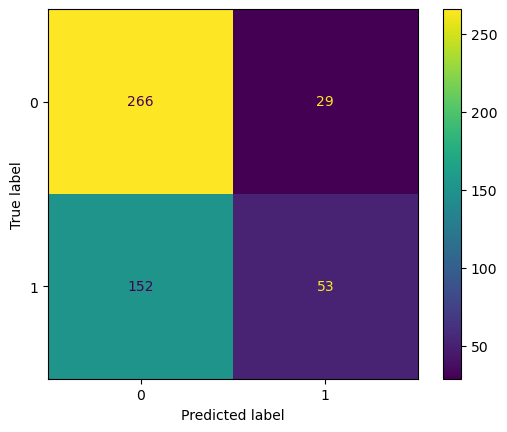

In [67]:
true = list(test[:500].label)
test_text = list(test[:500].text)

predup = []
for text in test_text:
    predup.append(custom_test(text, modelUP))
    
con_mat = confusion_matrix(true, predup)

con_mat_plot = metrics.ConfusionMatrixDisplay(confusion_matrix=con_mat, display_labels=[0,1])
con_mat_plot.plot()
plt.show()

## ModelDoWN

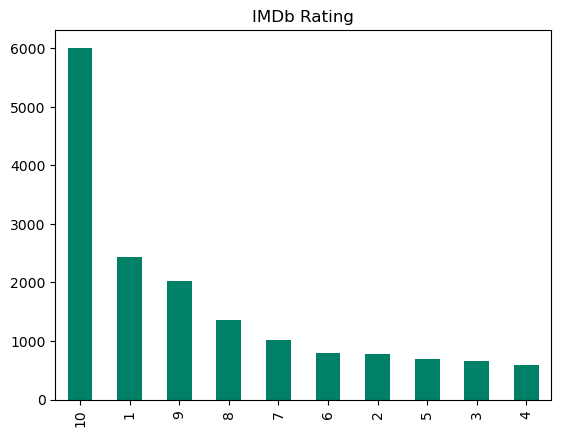

In [68]:
plot_rate(main_df)

In [43]:
ddf = main_df[main_df['label'] <= 5].copy()
ddf.label.value_counts()

1    2428
2     777
5     699
3     664
4     586
Name: label, dtype: int64

In [44]:
# Initialize an empty string
text = ''

# Iterate through each row of the dataframe
for index, row in ddf.iterrows():
    review = row['text']  # Get the review from the current row
    text += review + ' '   # Append the review to the text string with a space


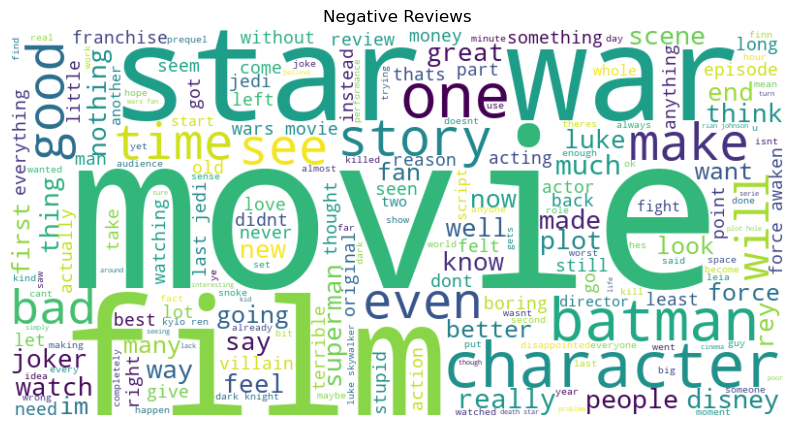

In [45]:
display_wc(text, 'Negative Reviews')

In [71]:
def level_down(x):
    '''
    Changes predicted levels to human brain level.
    '''
    if x in [4, 5, 3]:
        x = 0
    elif x in [1, 2]:
        x = 1
    return x

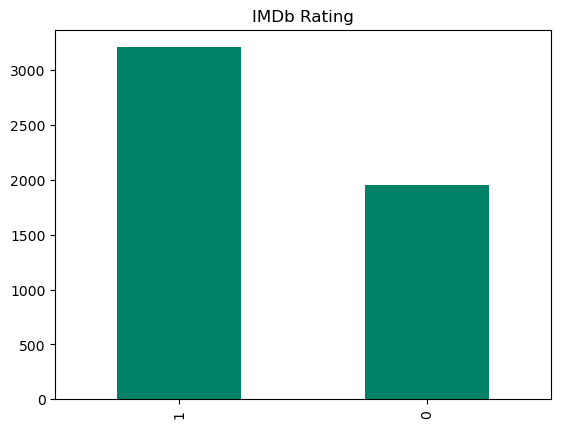

In [73]:
ddf['label'] = ddf['label'].apply(level_down)
plot_rate(ddf)

In [77]:
ddf.shape

(4944, 2)

In [92]:
def drop_one(n, df):
    
    for i in range(n):
        ind_to_drop = np.random.randint(1,4900)
        try:
            if df.label[ind_to_drop] == 1:
                df = df.drop(ind_to_drop)
        except:
            continue
    return df

(4718, 2)


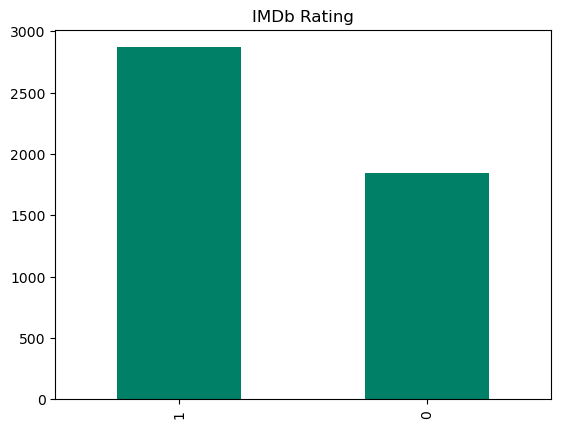

In [97]:
ddf = drop_one(5000, ddf)
print(ddf.shape)
plot_rate(ddf)

In [100]:
ddf.to_csv('/kaggle/working/dwn_data.csv', index=False)
ddf.tail()

,label,text
18427,0,the biggest issue with this movie is that disn...
18429,1,i had high hopes for this movie especially aft...
18459,1,i have never been so disappointed in a movie. ...
18483,0,walking into the crowded theater with others w...
18489,1,i will not drag about the movie itself plenty ...


In [101]:
np.random.seed(42)
train, test = train_test_split(ddf, test_size=0.2)
len(train), len(test)

(3774, 944)

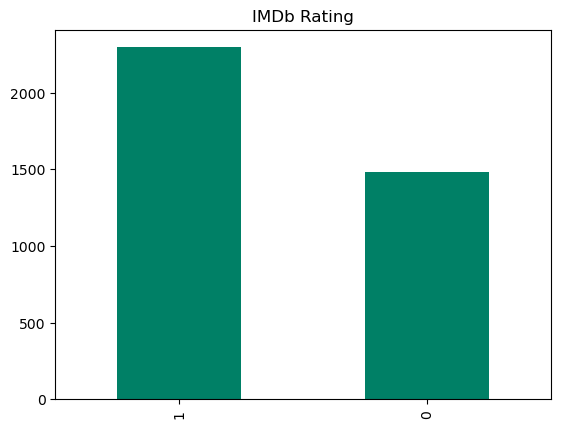

In [102]:
plot_rate(train)

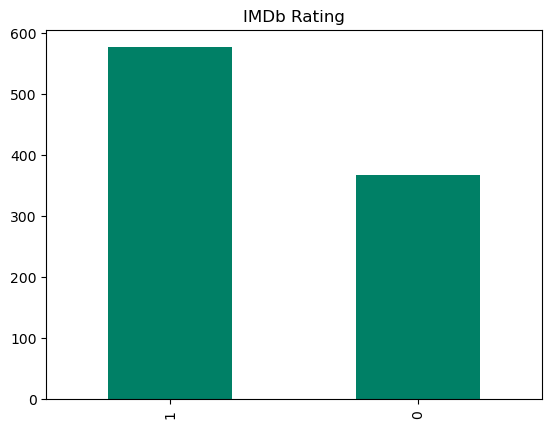

In [103]:
plot_rate(test)

In [104]:
train.to_csv('/kaggle/working/d_train.csv', index=False)
test.to_csv('/kaggle/working/d_test.csv', index=False)

In [105]:
dataset = load_dataset('csv', data_files={'train':'/kaggle/working/d_train.csv',
                                              'test':'/kaggle/working/d_test.csv'})

tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

tokenized_data = dataset.map(preprocess_function, batched=True)

data_collator=DataCollatorWithPadding(tokenizer=tokenizer,return_tensors='tf')

id2label = {0:0,1:1}
label2id = {0:0,1:1}
from transformers import create_optimizer
import tensorflow as tf
batch_size=16
num_epochs=2
batch_per_epoch=len(tokenized_data["train"])
total_train_steps=int(batch_per_epoch*num_epochs)
optimizer,schedule=create_optimizer(init_lr=2e-5,num_warmup_steps=0,num_train_steps=total_train_steps)

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-db27818df9717c88/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


/opt/conda/lib/python3.10/site-packages/datasets/packaged_modules/csv/csv.py:154: FutureWarning: the 'mangle_dupe_cols' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'mangle_dupe_cols'
  csv_file_reader = pd.read_csv(file, iterator=True, dtype=dtype, **self.config.read_csv_kwargs)
/opt/conda/lib/python3.10/site-packages/datasets/packaged_modules/csv/csv.py:154: FutureWarning: the 'mangle_dupe_cols' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'mangle_dupe_cols'
  csv_file_reader = pd.read_csv(file, iterator=True, dtype=dtype, **self.config.read_csv_kwargs)


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [106]:
modelDN=TFAutoModelForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',num_labels=2,id2label=id2label,label2id=label2id,ignore_mismatched_sizes=True
    
)
tf_train_set = modelDN.prepare_tf_dataset(
    tokenized_data["train"],
    shuffle=True,
    batch_size=16,
    collate_fn=data_collator,
)
tf_validation_set = modelDN.prepare_tf_dataset(
    tokenized_data["test"],
    shuffle=False,
    batch_size=16,
    collate_fn=data_collator,
)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [107]:
modelDN.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')])


In [108]:
# Slice the dataset from length 100 to 10
n = 50
sliced_dataset_train = tf_train_set.take(n)
sliced_dataset_test = tf_validation_set.take(n)

modelDN.fit(x=tf_train_set,validation_data=tf_validation_set, epochs=1)

235/235 [==============================] - 257s 985ms/step - loss: 0.5987 - accuracy: 0.6777 - val_loss: 0.5335 - val_accuracy: 0.7352


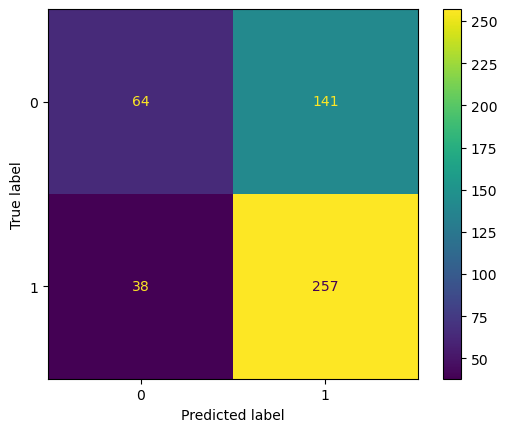

In [110]:
true = list(test[:500].label)
test_text = list(test[:500].text)

preddn = []
for text in test_text:
    preddn.append(custom_test(text, modelDN))
    
con_mat = confusion_matrix(true, preddn)

con_mat_plot = metrics.ConfusionMatrixDisplay(confusion_matrix=con_mat, display_labels=[0,1])
con_mat_plot.plot()
plt.show()

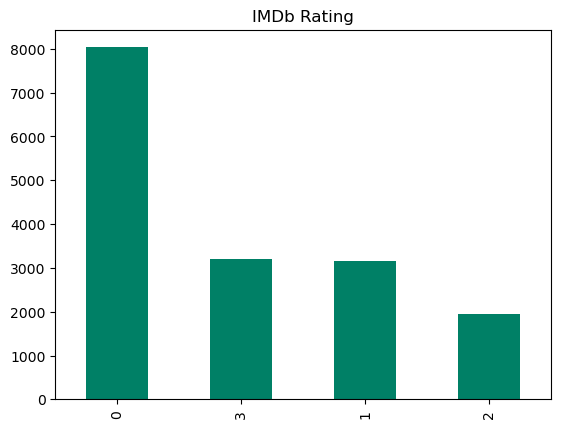

In [111]:
plot_rate(data)

In [112]:
ft =data.copy()

In [163]:
np.random.seed(42)
train, test = train_test_split(ft, test_size=0.2)
len(train), len(test)

(13082, 3271)

In [165]:
n = 3000
true = list(test[:n].label)
test_text = list(test[:n].text)

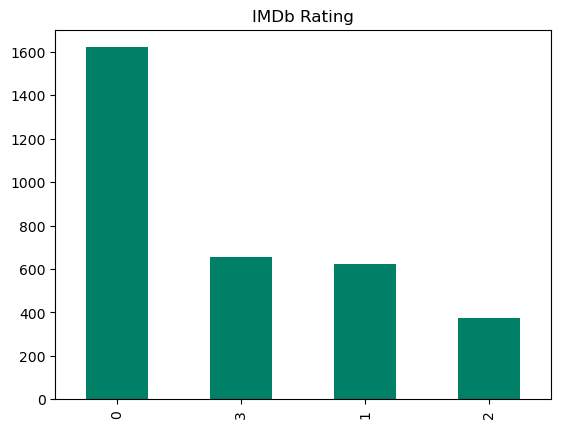

In [164]:
plot_rate(test)

In [119]:
def custom_test_model(text, model):
    inputs=tokenizer(text,return_tensors="tf")
    tf_outputs = model(inputs)                                  
    tf_predictions = tf.nn.softmax(tf_outputs[0], axis=-1) 
    # print(tf_predictions)
    logits=modelS(**inputs).logits
    # print("Logits :",logits)
    predicted_class_id = int(tf.math.argmax(logits, axis=-1)[0])
    return predicted_class_id

In [122]:
def final_prediction(test_text):
    '''
    Makes the final prediction ^_^
    '''
#     preds = []
#     predup = []
#     preddown = []
    fpred = []
    for text in test_text:
        s = custom_test_model(text, modelS)
#         preds.append(custom_test(text, modelS))
        if s == 0:
            # Sentiment Positive So check text with modelUP
            up = custom_test_model(text, modelUP)
            # Up will return 0(9,10)-->{0} or 1 (6,7, 8)-->{1}
            fpred.append(up)
        elif s == 1:
            # Sentiment negetive So check text with modelDN
            dn = custom_test_model(text, modelDN)
            # dn will return 0(4, 5, 3)-->{2} or 1 (1,2)-->{3}
            dn += 2
            fpred.append(dn)
    return fpred

In [117]:
level_df

,level,range
0,0,"[10, 9]"
1,1,"[8, 7, 6]"
2,2,"[3, 4, 5]"
3,3,"[1, 2]"


In [123]:
prediction = final_prediction(test_text)

In [124]:
true[:15]

[0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 2, 0, 0]

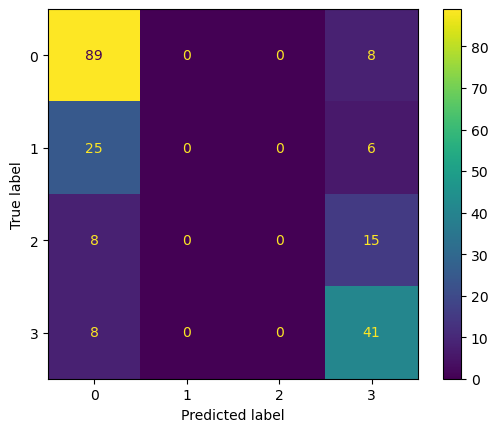

In [125]:
con_mat = confusion_matrix(true, prediction)

con_mat_plot = metrics.ConfusionMatrixDisplay(confusion_matrix=con_mat, 
                                              display_labels=[0,1, 2, 3])
con_mat_plot.plot()
plt.show()

In [127]:
def custom_test_up(text):
    inputs=tokenizer(text,return_tensors="tf")
    tf_outputs = modelS(inputs)                                  
    tf_predictions =np.argmax( tf.nn.softmax(tf_outputs[0], axis=-1) )
   
    if tf_predictions==0:
        tf_outputs = modelUP(inputs)                                  
        tf_predictions_final =np.argmax( tf.nn.softmax(tf_outputs[0], axis=-1) ) 
        
    else:
        tf_outputs = modelDN(inputs)                                  
        tf_predictions_final =np.argmax( tf.nn.softmax(tf_outputs[0], axis=-1) )+2
         
    return tf_predictions_final

In [129]:
text = 'This is a very bad movie. I hatedit. Very bad screenplay. Very bad direction and hope not to see it again.'
custom_test_up(text)

3

In [130]:
text = 'Very good movie. I loved every part of it. Highly recommended for everyone'
custom_test_up(text)

0

In [131]:
text = 'this is an average movie. Not that good not that bad. It was pretty decent and enjoyable but not that great.'
custom_test_up(text)

1

In [132]:
text = 'this is bellow average movie. Not that bad not good. It was not enjoyable. I would not recommend it but it was not worst.'
custom_test_up(text)

3

In [166]:
prediction = []
for text in test_text:
    prediction.append(custom_test_up(text))

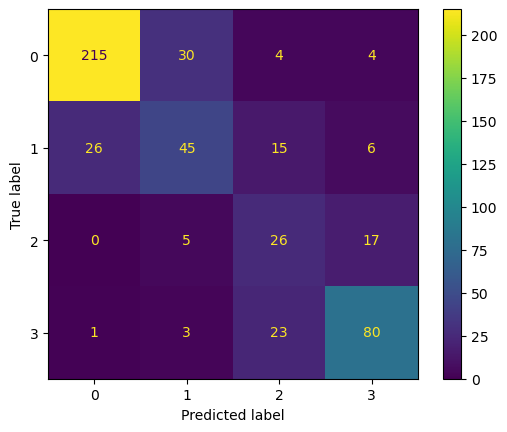

In [160]:
con_mat = confusion_matrix(true, prediction)

con_mat_plot = metrics.ConfusionMatrixDisplay(confusion_matrix=con_mat, display_labels=[0,1, 2, 3])
con_mat_plot.plot()
plt.show()

In [161]:
from sklearn.metrics import accuracy_score

# Calculate accuracy score
accuracy = accuracy_score(true, prediction)

print(f"Accuracy: {accuracy*100:.2f}%", )

Accuracy: 73.20%


In [162]:
level_df

,level,range
0,0,"[10, 9]"
1,1,"[8, 7, 6]"
2,2,"[3, 4, 5]"
3,3,"[1, 2]"


## For 3000 test data

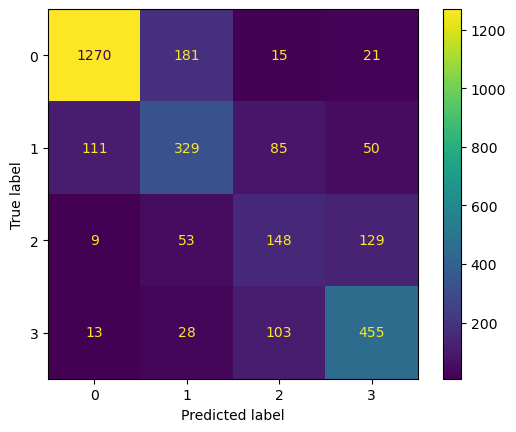

In [167]:
con_mat = confusion_matrix(true, prediction)

con_mat_plot = metrics.ConfusionMatrixDisplay(confusion_matrix=con_mat, display_labels=[0,1, 2, 3])
con_mat_plot.plot()
plt.show()

In [168]:
# Calculate accuracy score
accuracy = accuracy_score(true, prediction)

print(f"Accuracy: {accuracy*100:.2f}%", )

Accuracy: 73.40%


### author: `Minhazul Islam Nannu`, `Tanbeer Jubaer`